# **産業別売上高分析**

目的：産業別の理解を図るため、売上高データを視覚化します。

使っているデータは日本政府統計ウェブサイトから抽出しました。


### データ詳細

*   情報源：e-stat.go.jp
*   情報フォーマット：JSON
*   抽出するデータ：経済構造実態調査




### データ抽出

しなければならない事：APIの解析方法を理解必要があります

In [1]:
import requests
import pandas as pd

In [2]:
try:
  # JSONファイルを取り出す
  app_id = '1b32db0d63fefc9bc09c7074764b410f16efc222'
  url = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?appId=' + \
  app_id + '&lang=J&statsDataId=0003414037&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1'
  req = requests.get(url)
except requests.exceptions.TooManyRedirects:
  print("URLリダイレクトがループで固まらないよう、リクエストは停止しました。 URLをご確認ください")
  raise SystemExit()
except requests.exceptions.RequestException as e:
  # 他のエラーが発見
  raise SystemExit(e)

In [3]:
# 成功チェック
if req.status_code == 200:
  print("データ抽出成功しました。")
else:
  print("エラー発見：" + req.status_code)

データ抽出成功しました。


In [4]:
req_dict = req.json()
# 別のJSONレベルを確認してみる
#req_dict['GET_STATS_DATA']

In [5]:
extr = req_dict['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ'][1]

In [6]:
pd.json_normalize(extr['CLASS'])

,@code,@name,@level,@parentCode
0,00,E～R 産業計,1,NaN
1,01,E 製造業,2,00
2,0101,09 食料品製造業,3,01
3,010101,091 畜産食料品製造業,4,0101
4,010102,092 水産食料品製造業,4,0101
...,...,...,...,...
564,140504,929 他に分類されない事業サービス業,4,1405
565,1406,95 その他のサービス業,3,14
566,140601,951 集会場,4,1406
567,140602,952 と畜場,4,1406


API抽出セクション開発はまだ進行中です。完成したら、全処理のセクションを接続します。

### 前処理

In [7]:
import pandas as pd
import numpy as np

In [8]:
# CSVからデータセットを読み込む
df = pd.read_csv("JP_Industry_2019.csv")
# データセットを覗く
df.head()

,地域 コード,地域,時間軸 コード,時間軸,企業産業分類 コード,企業産業分類,/表章項目,企業等数,売上（収入）金額【百万円】,企業等数.1,売上（収入）金額【百万円】.1,企業等数.2,売上（収入）金額【百万円】.2
0,0,全国,2019000000,2019年,0,E～R 産業計,NaN,"1,333,501","1,520,656,648","1,204,653","1,328,807,082","128,848","191,849,566"
1,0,全国,2019000000,2019年,1,E 製造業,NaN,"204,017","413,224,430","202,019","412,385,485","1,998","838,945"
2,0,全国,2019000000,2019年,101,09 食料品製造業,NaN,"20,670","35,748,641","20,087","35,405,024",583,"343,616"
3,0,全国,2019000000,2019年,10101,091 畜産食料品製造業,NaN,"1,913","9,991,250","1,828","9,764,837",85,"226,413"
4,0,全国,2019000000,2019年,10102,092 水産食料品製造業,NaN,"4,422","4,664,091","4,341","4,643,805",81,"20,287"


In [9]:
# データ型の設定を確認
print(df.isna().sum())
print(df.dtypes)

# 文字列へのキャスト
df['企業産業分類'] = df['企業産業分類'].astype(str)

地域 コード               0
地域                   0
時間軸 コード              0
時間軸                  0
企業産業分類 コード           0
企業産業分類               0
/表章項目              569
企業等数                 0
売上（収入）金額【百万円】        0
企業等数.1               0
売上（収入）金額【百万円】.1      0
企業等数.2               0
売上（収入）金額【百万円】.2      0
dtype: int64
地域 コード               int64
地域                  object
時間軸 コード              int64
時間軸                 object
企業産業分類 コード           int64
企業産業分類              object
/表章項目              float64
企業等数                object
売上（収入）金額【百万円】       object
企業等数.1              object
売上（収入）金額【百万円】.1     object
企業等数.2              object
売上（収入）金額【百万円】.2     object
dtype: object


In [10]:
# 注目データフレームの列:
# 企業産業分類, 企業等数, 売上（収入）金額【百万円】
# 他の列が会社企業と会社以外の法人の区別をつけました
df = df[['企業産業分類', '企業等数', '売上（収入）金額【百万円】']]
df.head()

,企業産業分類,企業等数,売上（収入）金額【百万円】
0,E～R 産業計,"1,333,501","1,520,656,648"
1,E 製造業,"204,017","413,224,430"
2,09 食料品製造業,"20,670","35,748,641"
3,091 畜産食料品製造業,"1,913","9,991,250"
4,092 水産食料品製造業,"4,422","4,664,091"


In [11]:
# データセットにはトップレベルの行がありますが、それは使用しません
df = df[1:]

# もっとシンプルな列名をつける
df.columns = ["産業", "企業等数", "売上"]
df.head()

,産業,企業等数,売上
1,E 製造業,"204,017","413,224,430"
2,09 食料品製造業,"20,670","35,748,641"
3,091 畜産食料品製造業,"1,913","9,991,250"
4,092 水産食料品製造業,"4,422","4,664,091"
5,093 野菜缶詰・果実缶詰・農産保存食料品製造業,"1,433","856,417"


メモ：データセットから「製氷業」（16行目）と「たばこ製造業」（17行目）の情報が欠落しています．たばこ製造業の企業等数は一社だから、日本たばこ産業株式会社（JT）は日本企業の中で唯一、大きなシェアを持つ企業です。そこで、入力用にJTを選択します。JTの財務ハイライト（https://www.jti.co.jp/investors/individual/finance/index.html）によると、2019外販たばこ製品売上収益が6,115億円と	自社たばこ製品売上収益5,689億円です。

「飲料・たばこ・飼料製造業」のサブセクションの集計がどれくらいかわかっているから、「製氷業」の残り行の金額は1,753.438億円を推測することができます。


In [12]:
df[df['売上'] == 'X']

,産業,企業等数,売上
16,104 製氷業,128,X
17,105 たばこ製造業,1,X


In [13]:
# 産業と企業等数列の書式化
df['売上'].replace(',','', regex=True, inplace=True)
df['企業等数'].replace(',','', regex=True, inplace=True)

# 入力方法のために上記のセルを参照してください
df.at[16, '売上'] = '1753438'
df.at[17, '売上'] = '1180400'

# 残り列項目をintでキャストする
df['売上'] = df['売上'].astype('int64')
df['企業等数'] = df['企業等数'].astype('int64')

このデータセットには、産業とサブ産業の行があることに注目してください。この行は並べ替えや集計の邪魔になるから、行ラベルにします。

In [14]:
def CategoryLabel(dataset_df, mask, prefix_len, extract_col_name, category_col_name):
  # データを準備。オリジナルはコピーの影響を与えないようにしなければならない
  updated_df = dataset_df.copy(deep = True)
  category_df = updated_df.loc[mask]
  names = category_df[extract_col_name].unique()

  categories = []
  level_labels = []
  # カテゴリをゲットする
  for s in names:
    level_labels.append(s)
    #a = s.split(" ")
    # レベル接頭辞を削除
    a = (''.join([i for i in s[prefix_len+1:]]))
    categories.append(a.lstrip(' '))

  indexes = []
  # 行にラベルを付けるため、インデックスを取得する
  index_start_points = [i-1 for i in list(category_df.index.values)]
  indexes = index_start_points[1:]
  indexes.append(len(updated_df)+1)

  # 新データフレームを作成して,行で入力する
  updated_df[category_col_name] = ""
  i_target = 0

  i_target = indexes.pop(0)
  industry = categories.pop(0)
  # 一つ加えなければならないと最後の行に到達しない
  for i in range(0, len(updated_df)+1):
    if i == i_target+1 and len(indexes) != 0:
      i_target = indexes.pop(0)
      industry = categories.pop(0)
    updated_df.at[i, category_col_name] = industry
    
  # ラベル行を削除する
  updated_df = updated_df[~updated_df[extract_col_name].isin(level_labels)]
  updated_df.reset_index(inplace = True, drop = True)
  # Pandasバグの可能性かも：行が誤って作成されました（行インデックス０）
  updated_df.drop(len(updated_df)-1, inplace = True)
  
  # 次のprint文にテストに使用します
  # 行数はカテゴリの数と一致する必要があります
  #print('デバッグ: カテゴリの数: %d // 削除された行: %d' % (len(names), len(dataset_df) - len(updated_df)))
  return updated_df

In [15]:
# メイン産業用

# メインとサブセクションを示す
temp_series = df['産業'].str.split(' ', expand = True)[0]
# 産業の接頭辞は一文字だけ
mask = (temp_series.str.len() == 1)
# ラベル付けるためにメソッド呼び出す
ind_labeled_df = CategoryLabel(df, mask, 1, "産業", "主な産業")
ind_labeled_df

,産業,企業等数,売上,主な産業
0,09 食料品製造業,20670.0,35748641.0,製造業
1,091 畜産食料品製造業,1913.0,9991250.0,製造業
2,092 水産食料品製造業,4422.0,4664091.0,製造業
3,093 野菜缶詰・果実缶詰・農産保存食料品製造業,1433.0,856417.0,製造業
4,094 調味料製造業,1459.0,2822390.0,製造業
...,...,...,...,...
549,929 他に分類されない事業サービス業,17189.0,10685850.0,サービス業（他に分類されないもの）
550,95 その他のサービス業,946.0,388067.0,サービス業（他に分類されないもの）
551,951 集会場,744.0,219329.0,サービス業（他に分類されないもの）
552,952 と畜場,70.0,46919.0,サービス業（他に分類されないもの）


In [16]:
# サブ産業用

# 産業の接頭辞は二文字だけ
temp_series = ind_labeled_df['産業'].str.split(' ', expand = True)[0]
mask = (temp_series.str.len() == 2)

# ラベル付けるためにメソッド呼び出す
labeled_df = CategoryLabel(ind_labeled_df, mask, 2, "産業", "サブ産業")
labeled_df

,産業,企業等数,売上,主な産業,サブ産業
0,091 畜産食料品製造業,1913.0,9991250.0,製造業,食料品製造業
1,092 水産食料品製造業,4422.0,4664091.0,製造業,食料品製造業
2,093 野菜缶詰・果実缶詰・農産保存食料品製造業,1433.0,856417.0,製造業,食料品製造業
3,094 調味料製造業,1459.0,2822390.0,製造業,食料品製造業
4,095 糖類製造業,93.0,560548.0,製造業,食料品製造業
...,...,...,...,...,...
464,923 警備業,3522.0,2487820.0,サービス業（他に分類されないもの）,その他の事業サービス業
465,929 他に分類されない事業サービス業,17189.0,10685850.0,サービス業（他に分類されないもの）,その他の事業サービス業
466,951 集会場,744.0,219329.0,サービス業（他に分類されないもの）,その他のサービス業
467,952 と畜場,70.0,46919.0,サービス業（他に分類されないもの）,その他のサービス業


In [17]:
# レベル接頭辞を削除
def RemovePrefix(s):
    a = s.split(" ")
    return (''.join([i for i in s[4:]]))

labeled_df['産業'] = labeled_df['産業'].apply(RemovePrefix)

In [18]:
# 一企業当たりの平均売上高を算出する

labeled_df['売上高の平均'] = labeled_df['売上']/labeled_df['企業等数']
labeled_df['売上高の平均'] = labeled_df['売上高の平均'].astype(np.int64)
labeled_df

,産業,企業等数,売上,主な産業,サブ産業,売上高の平均
0,畜産食料品製造業,1913.0,9991250.0,製造業,食料品製造業,5222
1,水産食料品製造業,4422.0,4664091.0,製造業,食料品製造業,1054
2,野菜缶詰・果実缶詰・農産保存食料品製造業,1433.0,856417.0,製造業,食料品製造業,597
3,調味料製造業,1459.0,2822390.0,製造業,食料品製造業,1934
4,糖類製造業,93.0,560548.0,製造業,食料品製造業,6027
...,...,...,...,...,...,...
464,警備業,3522.0,2487820.0,サービス業（他に分類されないもの）,その他の事業サービス業,706
465,他に分類されない事業サービス業,17189.0,10685850.0,サービス業（他に分類されないもの）,その他の事業サービス業,621
466,集会場,744.0,219329.0,サービス業（他に分類されないもの）,その他のサービス業,294
467,と畜場,70.0,46919.0,サービス業（他に分類されないもの）,その他のサービス業,670


### データ集計


データを集計して以下の質問にお答えします：

*   どの産業が最高の売上
*   売上高の平均の面でどの産業が最も効率的
*   最高の売上を持っている産業の面でどの産業が最も大きなシェア



In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

In [20]:
!pip install japanize_matplotlib

In [21]:
# matplotlibは以下のライブラリがないと日本語にサポートされていません
import japanize_matplotlib

#### どの産業が最高の売上

In [22]:
# 主な産業ごとにグループすると売上を平均値。売上で並べ替え
agg_df = labeled_df.groupby(['主な産業']).mean().sort_values(by=['売上'], ascending = False)
# トップ８を入手する
agg_df = agg_df.head(8)
# グラフ凡例を作る
industry_legend = list(agg_df.index.values)
agg_plot = agg_df.reset_index()

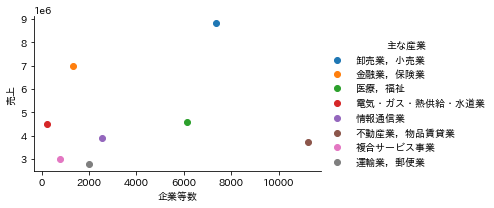

In [23]:
fg = sns.FacetGrid(data=agg_plot, hue='主な産業', hue_order=industry_legend, aspect=1.61)
fg.map(plt.scatter, '企業等数', '売上').add_legend()

#### 売上高の平均の面でどの産業が最も効率的

In [24]:
# 主な産業ごとにグループすると売上を平均値。売上高の平均で並べ替え
agg_df = labeled_df.groupby(['主な産業']).mean().sort_values(by=['売上高の平均'], ascending = False)
# トップ８を入手する
agg_df = agg_df.head(8)
# グラフ凡例を作る
industry_legend = list(agg_df.index.values)
agg_plot = agg_df.reset_index()

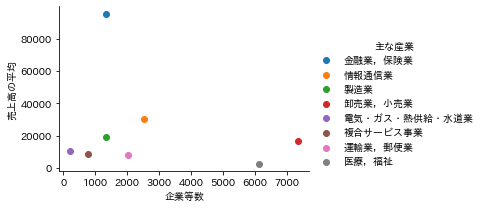

In [25]:
fg = sns.FacetGrid(data=agg_plot, hue='主な産業', hue_order=industry_legend, aspect=1.61)
fg.map(plt.scatter, '企業等数', '売上高の平均').add_legend()

#### 最高の売上を持っている産業の面でどの産業が最も大きなシェア

In [26]:
# 主な産業ごとに最も売上産業を入手する
idx = labeled_df.groupby(['主な産業'])['売上'].transform(max) == labeled_df['売上']
# 売上で並べ替え
largest_sales = labeled_df[idx].sort_values(['売上'], ascending = False)
largest_sales.reset_index(inplace = True, drop = True)

industry_sales = labeled_df.groupby(['主な産業']).sum()
industry_sales = industry_sales['売上']

In [27]:
chart_data = largest_sales.head(5)
stack_chart = []
# グラフ用のデータフレームに変換するための辞書を作る
for i in range(0, len(chart_data)):
    industry = chart_data.loc[i, "主な産業"]
    enterprise = chart_data.loc[i, "産業"]
    enterprise_sales = chart_data.loc[i, "売上"]

    # マーケットシェアの割合を計算する
    mkt_share = round((enterprise_sales / industry_sales[industry]),4)*100
    # 他の産業を持っているマーケットシェア
    remaining = 100 - mkt_share

    stack_chart.append(
        {
            '主な産業': industry,
            '産業': enterprise,
            '売上': mkt_share,
            '主な産業の残り売上': remaining
        }
    )
stack_df = pd.DataFrame(stack_chart)

In [28]:
stack_df

,主な産業,産業,売上,主な産業の残り売上
0,製造業,自動車・同附属品製造業,17.36,82.64
1,医療，福祉,社会保険事業団体,56.21,43.79
2,金融業，保険業,生命保険業,39.27,60.73
3,卸売業，小売業,食料・飲料卸売業,6.63,93.37
4,情報通信業,ソフトウェア業,37.19,62.81


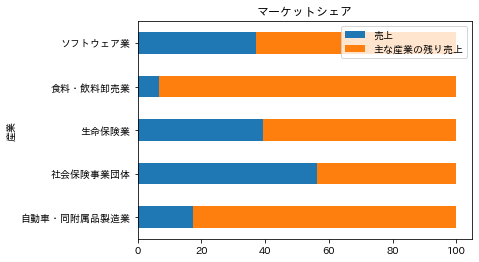

In [29]:
stack_df.plot(
    x = '産業',
    kind = 'barh',
    stacked = True,
    title = 'マーケットシェア',
    mark_right = True
)